In [2]:
!pip install umap-learn
!pip install gensim
!pip install wordcloud
!pip install sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 3.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.6/60.6 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 47.9 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.14.1
    Uninstalling scipy-1.14.1:
      Successfully uninstalled scipy-1.14.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cuml 24.8.0 requires cupy-cuda11x>=12.0.0, which is not installed.
cesium 0.12.3 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
libpysal 4.9.2 requires packaging>=22, but you have packaging 21.3 which is incompatible.
libpysal 4.9.2 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.
tsfres

In [3]:
import numpy as np
import pandas as pd
import nltk
import re
import warnings

import tqdm
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.exceptions import ConvergenceWarning

from sklearn.decomposition import PCA, TruncatedSVD
from scipy.sparse import issparse
from scipy import sparse

from scipy.stats import mode
from umap import UMAP
from sklearn.cluster import KMeans, AgglomerativeClustering,SpectralClustering
from sklearn.metrics import calinski_harabasz_score, adjusted_rand_score, confusion_matrix, classification_report
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from gensim.models import Word2Vec
from sklearn.preprocessing import StandardScaler

In [4]:
# Specify a custom directory for downloading NLTK data
download_dir = '/usr/share/nltk_data'
warnings.filterwarnings("ignore", category=ConvergenceWarning)

# Append the directory to NLTK's data path
nltk.data.path.append(download_dir)

# Download the required NLTK data
nltk.download('wordnet', download_dir=download_dir)

nltk.download('punkt', download_dir=download_dir)
nltk.download('stopwords', download_dir=download_dir)
nltk.download('omw-1.4', download_dir=download_dir)  # For supporting languages

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


True

In [5]:
# Run NLTK downloader for 'wordnet'
!python3 -m nltk.downloader wordnet

# Unzip the downloaded WordNet data to the desired directory
!yes | unzip -q /usr/share/nltk_data/corpora/wordnet.zip -d /usr/share/nltk_data/corpora

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


/opt/conda/lib/python3.10/runpy.py:126: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
yes: standard output: Broken pipe


In [6]:
# Load the dataset from Kaggle directory
file_path = '/kaggle/input/ag-news-classification-dataset/train.csv'
df = pd.read_csv(file_path, header=None)

# Assign column names
df.columns = ["Class Index", "Title", "Description"]

# Remove the header row if present
df = df.iloc[1:].reset_index(drop=True)

# Convert the "Class Index" column to integers if necessary
df["Class Index"] = df["Class Index"].astype(int)

# Reduce dataset to 5000 samples per class
df = df.groupby("Class Index").apply(lambda x: x.sample(n=5000, random_state=42)).reset_index(drop=True)

# Shuffle the reduced dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

/tmp/ipykernel_30/3940715604.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby("Class Index").apply(lambda x: x.sample(n=5000, random_state=42)).reset_index(drop=True)


In [7]:
print("Dataset Structure:\n", df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Class Index  20000 non-null  int64 
 1   Title        20000 non-null  object
 2   Description  20000 non-null  object
dtypes: int64(1), object(2)
memory usage: 468.9+ KB
Dataset Structure:
 None


In [8]:
df.head()

,Class Index,Title,Description
0,3,"UPDATE 3-Allied Waste again cuts forecast, sha...","Allied Waste Industries Inc. (AW.N: Quote, Pro..."
1,1,Hirst restaurant sale makes 11m,Fixtures and fittings from Damien Hirst's rest...
2,2,City boss Keegan fined over referee insults,Manchester City manager Kevin Keegan has been ...
3,1,Ukrainian Government Blamed for Poisoning,Opposition leader Viktor Yushchenko said Thurs...
4,3,Update 1: EU Trade Chief Seeks Tariff Break Ov...,The European Union #39;s top trade official pr...


In [9]:
# Print samples as {title}\n{description}
for title, description in zip(df["Title"].head(5), df["Description"].head(5)):
    print(f"{title}\n{description}\n")

UPDATE 3-Allied Waste again cuts forecast, shares drop
Allied Waste Industries Inc. (AW.N: Quote, Profile, Research) on Tuesday cut its 2004 earnings forecast for the second time in three months as investment costs rose, sending its stock down more than 9 percent.

Hirst restaurant sale makes 11m
Fixtures and fittings from Damien Hirst's restaurant Pharmacy sell for 11.1, 8m more than expected.

City boss Keegan fined over referee insults
Manchester City manager Kevin Keegan has been fined 8,500 pounds for insulting referee Steve Dunn after his side #39;s Premier League defeat at Newcastle United last month.

Ukrainian Government Blamed for Poisoning
Opposition leader Viktor Yushchenko said Thursday that he was sure he was poisoned by the Ukrainian government after a Sept. 5 dinner with the head of the country's security service.

Update 1: EU Trade Chief Seeks Tariff Break Overhaul
The European Union #39;s top trade official proposed an overhaul of trade discounts to developing countr

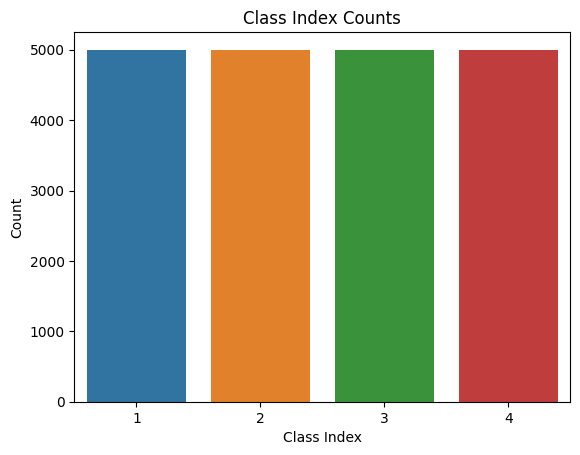

In [10]:
# Plot Class Index distribution
sns.countplot(x='Class Index', data=df)
plt.title("Class Index Counts")
plt.xlabel("Class Index")
plt.ylabel("Count")
plt.show()

In [11]:
# Summarize data distributions
df['Text_Length'] = df['Description'].str.len()
category_counts = df['Class Index'].value_counts()

print(f"Category Counts:\n{category_counts}")
print(f"Text Length Stats:\n{df['Text_Length'].describe()}")

Category Counts:
Class Index
3    5000
1    5000
2    5000
4    5000
Name: count, dtype: int64
Text Length Stats:
count    20000.000000
mean       193.364600
std         63.713295
min          6.000000
25%        155.000000
50%        188.000000
75%        218.000000
max        957.000000
Name: Text_Length, dtype: float64


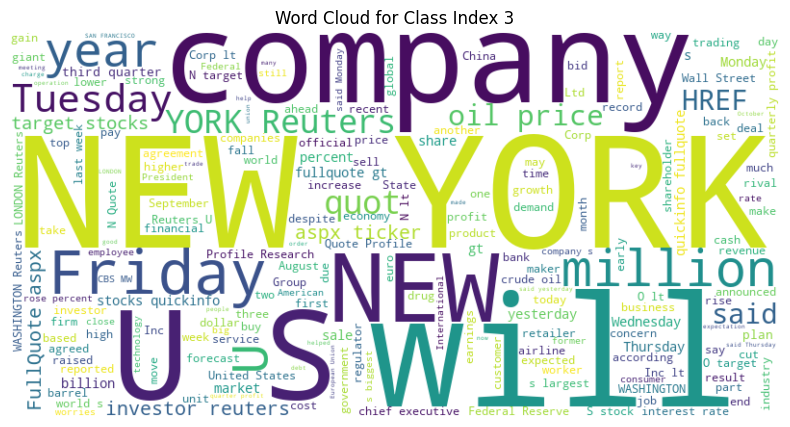

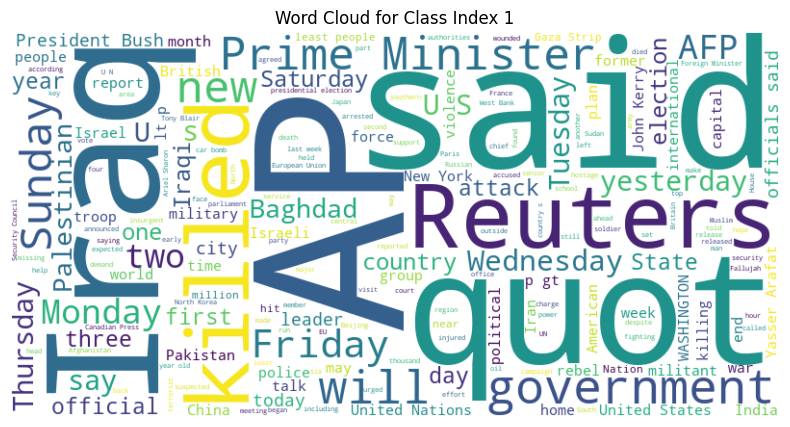

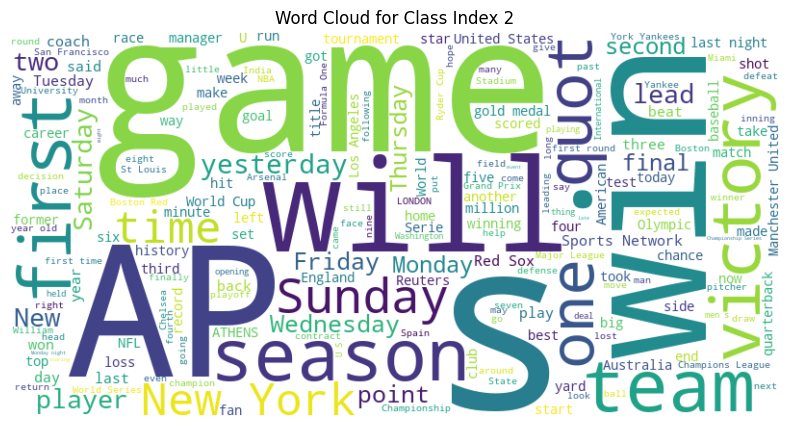

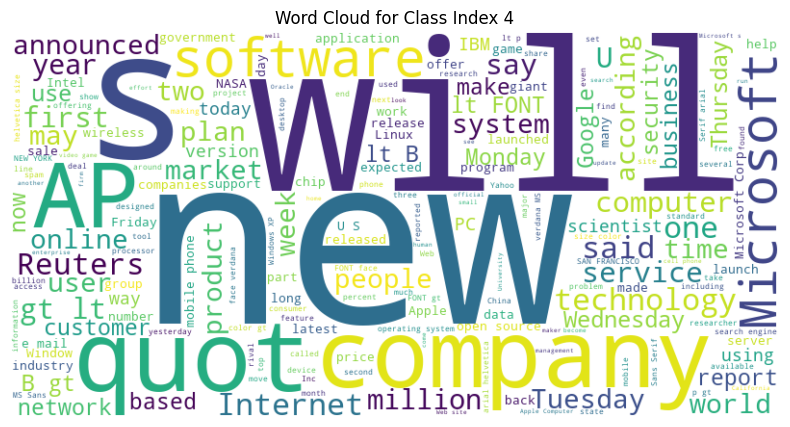

In [12]:
# Plot word clouds for each Class Index
for category in df["Class Index"].unique():
    category_text = " ".join(df[df["Class Index"] == category]["Description"].dropna())
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(category_text)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.title(f"Word Cloud for Class Index {category}")
    plt.axis("off")
    plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


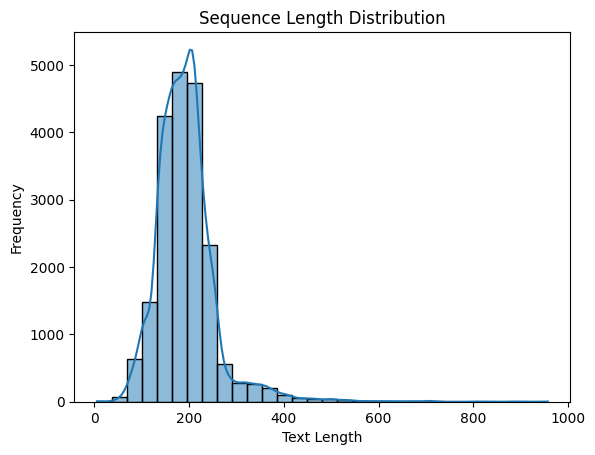

In [13]:
#Shows the variability in text length across articles.
sns.histplot(df['Text_Length'], kde=True, bins=30)
plt.title("Sequence Length Distribution")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

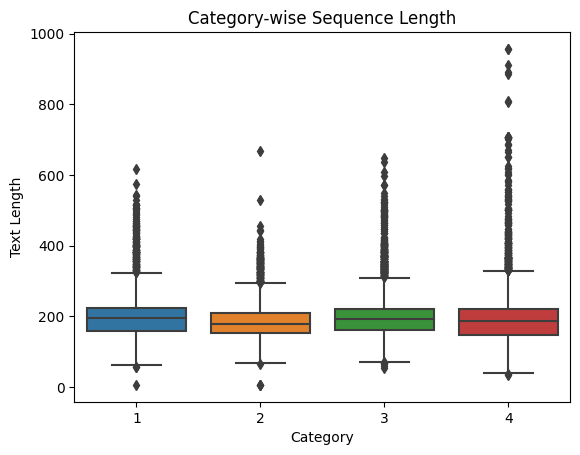

In [14]:
sns.boxplot(x='Class Index', y='Text_Length', data=df)
plt.title("Category-wise Sequence Length")
plt.xlabel("Category")
plt.ylabel("Text Length")
plt.show()

In [15]:
def preprocess_text(sentence):
    # Lowercase
    sentence = sentence.lower()
    
    # Remove all non-alphabets (punctuation, numbers, new-line characters and extra-spaces)
    sentence = re.sub(r'[^a-zA-Z]+', ' ', sentence)
    sentence = sentence.replace('\n', '')
    # sentence = re.sub('\s\s+', ' ', sentence)
    
    # Tokenize & remove stop-words
    word_list = nltk.word_tokenize(sentence)    
    stopwords_list = set(nltk.corpus.stopwords.words('english'))
    word_list = [word for word in word_list if word not in stopwords_list]
    
    # Remove very small words, length < 3, they don't contribute any useful information
    word_list = [word for word in word_list if len(word) > 3]
        
    # Stem & Lemmatize
    porter_stemmer = nltk.stem.PorterStemmer()
    lemmatizer = nltk.stem.WordNetLemmatizer()
    word_list = [porter_stemmer.stem(word) for word in word_list]
    word_list = [lemmatizer.lemmatize(word) for word in word_list]
    
    sentence = ' '.join(word_list)
    
    return sentence

In [16]:
# Preprocess the news description
tqdm.tqdm.pandas()
df['news_tokenized'] = df['Description'].progress_apply(lambda x: preprocess_text(str(x)))

100%|██████████| 20000/20000 [00:16<00:00, 1220.77it/s]


In [17]:
def get_tfidf_embeddings(documents):
    vectorizer = TfidfVectorizer(max_features=1000)
    return vectorizer.fit_transform(documents).toarray()

tfidf_embeddings = get_tfidf_embeddings(df['news_tokenized'])


In [ ]:
def get_word2vec_embeddings(documents):
    sentences = [doc.split() for doc in documents]
    model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)
    embeddings = [np.mean([model.wv[word] for word in doc.split() if word in model.wv] or [np.zeros(100)], axis=0)
                  for doc in documents]
    return np.array(embeddings)

word2vec_embeddings = get_word2vec_embeddings(df['news_tokenized'])


In [ ]:
def get_bert_embeddings(documents):
    model = SentenceTransformer('all-MiniLM-L6-v2')
    return np.array(model.encode(documents))

bert_embeddings = get_bert_embeddings(df['news_tokenized'])

In [ ]:
def get_doc2vec_embeddings(documents):
    tagged_data = [TaggedDocument(words=doc.split(), tags=[i]) for i, doc in enumerate(documents)]
    model = Doc2Vec(tagged_data, vector_size=100, window=5, min_count=1, workers=4)
    return np.array([model.dv[i] for i in range(len(documents))])

doc2vec_embeddings = get_doc2vec_embeddings(df['news_tokenized'])

In [ ]:
def reduce_dimensions(embeddings, n_components=100):
    if issparse(embeddings):
        # For sparse data, use Truncated SVD
        print("Reducing dimensions using Truncated SVD for sparse embeddings...")
        reducer = TruncatedSVD(n_components=n_components, random_state=42)
    else:
        # For dense data, use PCA
        print("Reducing dimensions using PCA for dense embeddings...")
        reducer = PCA(n_components=n_components, random_state=42)
    
    reduced_embeddings = reducer.fit_transform(embeddings)
    print(f"Dimensionality reduced to {reduced_embeddings.shape[1]} dimensions.")
    return reduced_embeddings

In [ ]:
tfidf_embeddings_reduced = reduce_dimensions(tfidf_embeddings, n_components=100)
word2vec_embeddings_reduced = reduce_dimensions(word2vec_embeddings, n_components=100)
bert_embeddings_reduced = reduce_dimensions(bert_embeddings, n_components=100)
doc2vec_embeddings_reduced = reduce_dimensions(doc2vec_embeddings, n_components=100)

In [ ]:
def run_kmeans(embeddings, true_labels, n_clusters=4):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, max_iter=500)
    cluster_labels = kmeans.fit_predict(embeddings)
    
    # Calculate Calinski-Harabasz Index
    calinski_harabasz = calinski_harabasz_score(embeddings, cluster_labels)
    
    # Calculate Adjusted Rand Index (ARI)
    ari = adjusted_rand_score(true_labels, cluster_labels)
    
    return cluster_labels, ari, calinski_harabasz

In [ ]:
def run_agglomerative(embeddings, true_labels, n_clusters=4):
    # Initialize and fit Agglomerative Clustering
    agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
    agglomerative_labels = agglomerative.fit_predict(embeddings)

    # Calculate Calinski-Harabasz Index
    calinski_harabasz = calinski_harabasz_score(embeddings, agglomerative_labels)

    # Calculate ARI (if true_labels are provided)
    ari = None
    if true_labels is not None:
        ari = adjusted_rand_score(true_labels, agglomerative_labels)

    # Return labels, Calinski-Harabasz Index, and ARI (if available)
    return agglomerative_labels, ari, calinski_harabasz

In [ ]:
def run_spectral_clustering(embeddings, true_labels, n_clusters=4):
    # Initialize and fit Spectral Clustering
    spectral = SpectralClustering(
        n_clusters=n_clusters,
        affinity='nearest_neighbors',
        random_state=42,
        assign_labels='kmeans'
    )
    cluster_labels = spectral.fit_predict(embeddings)

    # Calculate Calinski-Harabasz Index
    calinski_harabasz = calinski_harabasz_score(embeddings, cluster_labels)

    # Calculate ARI
    ari = adjusted_rand_score(true_labels, cluster_labels)

    return cluster_labels, ari, calinski_harabasz

In [ ]:
# Function to evaluate clustering and plot confusion matrix
def evaluate_clustering(true_labels, predicted_labels, algorithm_name="Algorithm"):
    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    
    # Compute Precision, Recall, F1-Score
    report = classification_report(true_labels, predicted_labels, zero_division=0, output_dict=True)
    
    # Convert the report to dictionaries for precision, recall, and F1
    precision = {f"Class {k}": v['precision'] for k, v in report.items() if k.isdigit()}
    recall = {f"Class {k}": v['recall'] for k, v in report.items() if k.isdigit()}
    f1 = {f"Class {k}": v['f1-score'] for k, v in report.items() if k.isdigit()}
    
    # Plot Confusion Matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(true_labels),
                yticklabels=np.unique(true_labels))
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"Confusion Matrix - {algorithm_name}")
    plt.show()
    
    return {"Confusion Matrix": cm, "Precision": precision, "Recall": recall, "F1-Score": f1}

In [ ]:
def run_svd_for_tfidf(embeddings, n_components=50):
    # Apply TruncatedSVD for dimensionality reduction (better for sparse data like TF-IDF)
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    reduced_embeddings = svd.fit_transform(embeddings)
    return reduced_embeddings


In [ ]:
def umap_visualization(embeddings, cluster_labels, title="UMAP Visualization"):
    # Apply SVD for dimensionality reduction if embeddings are TF-IDF
    if isinstance(embeddings, sparse.csr_matrix):  # Check if the embeddings are sparse (like TF-IDF)
        embeddings = run_svd_for_tfidf(embeddings, n_components=50)  # Reduce dimensions

    # Apply UMAP for dimensionality reduction to 2D
    reducer = UMAP(n_neighbors=15, min_dist=0.1, metric='euclidean')
    umap_embeddings = reducer.fit_transform(embeddings)

    # Create a DataFrame for visualization
    df_umap = pd.DataFrame(umap_embeddings, columns=["UMAP1", "UMAP2"])
    df_umap['Cluster'] = cluster_labels

    # Plot the UMAP results
    plt.figure(figsize=(10, 8))
    sns.scatterplot(data=df_umap, x="UMAP1", y="UMAP2", hue="Cluster", palette="viridis", s=100, alpha=0.7)
    plt.title(title, fontsize=16)
    plt.show()


### Experiment 1: Applying K-Means, Agglomerative and Spectral Clustering on TF-IDF Embeddings

In [ ]:
print("\n### Experiment 1: TF-IDF Embeddings ###")
scaled_tfidf_embeddings = StandardScaler().fit_transform(tfidf_embeddings)  # Scaling for clustering

In [ ]:
# K-Means
kmeans_labels, kmeans_ari, kmeans_purity = run_kmeans(scaled_tfidf_embeddings, df['Class Index'])
print(f"K-Means: ARI = {kmeans_ari:.3f}, Purity = {kmeans_purity:.3f}")
kmeans_metrics = evaluate_clustering(df['Class Index'], kmeans_labels, algorithm_name="K-Means (TF-IDF)")

In [ ]:
# UMAP visualization for K-Means
umap_visualization(scaled_tfidf_embeddings, kmeans_labels, title="K-Means (TF-IDF) UMAP Visualization")

In [ ]:
# Agglomerative
agglomerative_labels, agglomerative_ari, agglomerative_purity = run_agglomerative(scaled_tfidf_embeddings, df['Class Index'])
print(f"Agglomerative: ARI = {agglomerative_ari:.3f}, Purity = {agglomerative_purity:.3f}")
agglomerative_metrics = evaluate_clustering(df['Class Index'], agglomerative_labels, algorithm_name="Agglomerative (TF-IDF)")


In [ ]:
# UMAP visualization for Agglomerative
umap_visualization(scaled_tfidf_embeddings, agglomerative_labels, title="Agglomerative (TF-IDF) UMAP Visualization")

In [ ]:
# Spectral Clustering
spectral_labels, spectral_ari, spectral_purity = run_spectral_clustering(scaled_tfidf_embeddings, df['Class Index'], n_clusters=4)
print(f"Spectral Clustering: ARI = {spectral_ari:.3f}, Purity = {spectral_purity:.3f}")
spectral_metrics = evaluate_clustering(df['Class Index'], spectral_labels, algorithm_name="Spectral Clustering (TF-IDF)")

In [ ]:
# UMAP visualization for Spectral Clustering
umap_visualization(scaled_tfidf_embeddings, spectral_labels, title="Spectral Clustering (TF-IDF) UMAP Visualization")

### Experiment 2: Applying K-Means, Agglomerative and Spectral Clustering on SBERT Embeddings

In [ ]:
print("\n### Experiment 2: BERT Embeddings ###")
scaled_bert_embeddings = StandardScaler().fit_transform(bert_embeddings)  # Scaling for clustering

In [ ]:
# K-Means
kmeans_labels, kmeans_ari, kmeans_purity = run_kmeans(scaled_bert_embeddings, df['Class Index'])
print(f"K-Means: ARI = {kmeans_ari:.3f}, Purity = {kmeans_purity:.3f}")
kmeans_metrics = evaluate_clustering(df['Class Index'], kmeans_labels, algorithm_name="K-Means (BERT)")

In [ ]:
# UMAP visualization for K-Means
umap_visualization(scaled_bert_embeddings, kmeans_labels, title="K-Means (BERT) UMAP Visualization")

In [ ]:
# Agglomerative
agglomerative_labels, agglomerative_ari, agglomerative_purity = run_agglomerative(scaled_bert_embeddings, df['Class Index'])
print(f"Agglomerative: ARI = {agglomerative_ari:.3f}, Purity = {agglomerative_purity:.3f}")
agglomerative_metrics = evaluate_clustering(df['Class Index'], agglomerative_labels, algorithm_name="Agglomerative (BERT)")

In [ ]:
# UMAP visualization for Agglomerative
umap_visualization(scaled_bert_embeddings, agglomerative_labels, title="Agglomerative (BERT) UMAP Visualization")

In [ ]:
# Spectral Clustering
spectral_labels, spectral_ari, spectral_purity = run_spectral_clustering(scaled_bert_embeddings, df['Class Index'], n_clusters=4)
print(f"Spectral Clustering: ARI = {spectral_ari:.3f}, Purity = {spectral_purity:.3f}")
spectral_metrics = evaluate_clustering(df['Class Index'], spectral_labels, algorithm_name="Spectral Clustering (BERT)")

In [ ]:
# UMAP visualization for Spectral Clustering
umap_visualization(scaled_bert_embeddings, spectral_labels, title="Spectral Clustering (BERT) UMAP Visualization")

### Experiment 3: Applying K-Means, Agglomerative and Spectral Clustering on Word2Vec Embeddings

In [ ]:
print("\n### Experiment 3: Word2Vec Embeddings ###")
scaled_word2vec_embeddings = StandardScaler().fit_transform(word2vec_embeddings)  # Scaling for clustering

In [ ]:
# K-Means
kmeans_labels, kmeans_ari, kmeans_purity = run_kmeans(scaled_word2vec_embeddings, df['Class Index'])
print(f"K-Means: ARI = {kmeans_ari:.3f}, Purity = {kmeans_purity:.3f}")
kmeans_metrics = evaluate_clustering(df['Class Index'], kmeans_labels, algorithm_name="K-Means (Word2Vec)")

In [ ]:
# UMAP visualization for K-Means
umap_visualization(scaled_word2vec_embeddings, kmeans_labels, title="K-Means (Word2Vec) UMAP Visualization")

In [ ]:
# Agglomerative
agglomerative_labels, agglomerative_ari, agglomerative_purity = run_agglomerative(scaled_word2vec_embeddings, df['Class Index'])
print(f"Agglomerative: ARI = {agglomerative_ari:.3f}, Purity = {agglomerative_purity:.3f}")
agglomerative_metrics = evaluate_clustering(df['Class Index'], agglomerative_labels, algorithm_name="Agglomerative (Word2Vec)")

In [ ]:
# UMAP visualization for Agglomerative
umap_visualization(scaled_word2vec_embeddings, agglomerative_labels, title="Agglomerative (Word2Vec) UMAP Visualization")

In [ ]:
# Spectral Clustering
spectral_labels, spectral_ari, spectral_purity = run_spectral_clustering(scaled_word2vec_embeddings, df['Class Index'], n_clusters=4)
print(f"Spectral Clustering: ARI = {spectral_ari:.3f}, Purity = {spectral_purity:.3f}")
spectral_metrics = evaluate_clustering(df['Class Index'], spectral_labels, algorithm_name="Spectral Clustering (Word2Vec)")

In [ ]:
# UMAP visualization for Spectral Clustering
umap_visualization(scaled_word2vec_embeddings, spectral_labels, title="Spectral Clustering (Word2Vec) UMAP Visualization")

### Experiment 4: Applying K-Means, Agglomerative and Spectral Clustering on Doc2Vec Embeddings

In [ ]:
print("\n### Experiment 4: Doc2Vec Embeddings ###")
scaled_doc2vec_embeddings = StandardScaler().fit_transform(doc2vec_embeddings)  # Scaling for clustering

In [ ]:
# K-Means
kmeans_labels, kmeans_ari, kmeans_purity = run_kmeans(scaled_doc2vec_embeddings, df['Class Index'])
print(f"K-Means: ARI = {kmeans_ari:.3f}, Purity = {kmeans_purity:.3f}")
kmeans_metrics = evaluate_clustering(df['Class Index'], kmeans_labels, algorithm_name="K-Means (Doc2Vec)")

In [ ]:
# UMAP visualization for K-Means
umap_visualization(scaled_doc2vec_embeddings, kmeans_labels, title="K-Means (Doc2Vec) UMAP Visualization")

In [ ]:
# Agglomerative
agglomerative_labels, agglomerative_ari, agglomerative_purity = run_agglomerative(scaled_doc2vec_embeddings, df['Class Index'])
print(f"Agglomerative: ARI = {agglomerative_ari:.3f}, Purity = {agglomerative_purity:.3f}")
agglomerative_metrics = evaluate_clustering(df['Class Index'], agglomerative_labels, algorithm_name="Agglomerative (Doc2Vec)")

In [ ]:
# UMAP visualization for Agglomerative
umap_visualization(scaled_doc2vec_embeddings, agglomerative_labels, title="Agglomerative (Doc2Vec) UMAP Visualization")

In [ ]:
# Spectral Clustering
spectral_labels, spectral_ari, spectral_purity = run_spectral_clustering(scaled_doc2vec_embeddings, df['Class Index'], n_clusters=4)
print(f"Spectral Clustering: ARI = {spectral_ari:.3f}, Purity = {spectral_purity:.3f}")
spectral_metrics = evaluate_clustering(df['Class Index'], spectral_labels, algorithm_name="Spectral Clustering (Doc2Vec)")

In [ ]:
# UMAP visualization for Spectral Clustering
umap_visualization(scaled_doc2vec_embeddings, spectral_labels, title="Spectral Clustering (Doc2Vec) UMAP Visualization")

In [ ]:
class ClusterFusion :
    def __init__(self, n_clusters=4, random_state=42):
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=random_state, max_iter=500)
        self.agglomerative = AgglomerativeClustering(n_clusters=n_clusters)
        self.spectral = SpectralClustering(
            n_clusters=n_clusters, affinity='nearest_neighbors', random_state=random_state, assign_labels='kmeans'
        )
        self.cluster_labels = None

    def fit_predict(self, embeddings, true_labels=None):
        # Fit KMeans
        kmeans_labels = self.kmeans.fit_predict(embeddings)
        kmeans_ch = calinski_harabasz_score(embeddings, kmeans_labels)
        kmeans_ari = adjusted_rand_score(true_labels, kmeans_labels) if true_labels is not None else None

        # Fit Agglomerative Clustering
        agglomerative_labels = self.agglomerative.fit_predict(embeddings)
        agglomerative_ch = calinski_harabasz_score(embeddings, agglomerative_labels)
        agglomerative_ari = adjusted_rand_score(true_labels, agglomerative_labels) if true_labels is not None else None

        # Fit Spectral Clustering
        spectral_labels = self.spectral.fit_predict(embeddings)
        spectral_ch = calinski_harabasz_score(embeddings, spectral_labels)
        spectral_ari = adjusted_rand_score(true_labels, spectral_labels) if true_labels is not None else None

        # Ensemble Voting: Use mode across the cluster labels
        all_labels = np.array([kmeans_labels, agglomerative_labels, spectral_labels])
        ensemble_labels = mode(all_labels, axis=0).mode.flatten()

        # Compute ensemble metrics
        ensemble_ch = calinski_harabasz_score(embeddings, ensemble_labels)
        ensemble_ari = adjusted_rand_score(true_labels, ensemble_labels) if true_labels is not None else None

        # Print the ensemble results
        print("Ensemble Clustering - Calinski-Harabasz: {:.2f}, ARI: {:.2f}".format(ensemble_ch, ensemble_ari if ensemble_ari is not None else -1))

        # Return only the ensemble results
        return ensemble_labels, ensemble_ch, ensemble_ari

    def get_labels(self):
        # Return the labels of the current ensemble clustering
        return self.cluster_labels["Ensemble"]["Labels"]

    def get_metrics(self):
        # Return metrics of the current ensemble clustering
        return {
            "Calinski-Harabasz": self.cluster_labels["Ensemble"]["Calinski-Harabasz"],
            "ARI": self.cluster_labels["Ensemble"]["ARI"],
        }

In [ ]:
# Initialize the Ensemble Cluster class
ensemble_cluster = ClusterFusion(n_clusters=4, random_state=42)

# Fit and predict using the ensemble clustering model
ensemble_labels, ensemble_ch, ensemble_ari = ensemble_cluster.fit_predict(scaled_bert_embeddings, true_labels=df['Class Index'])

# Output the results
print(f"Ensemble Clustering - Calinski-Harabasz: {ensemble_ch:.2f}, ARI: {ensemble_ari:.2f}")

In [ ]:
fusion_metrics = evaluate_clustering(df['Class Index'], spectral_labels, algorithm_name="Spectral Clustering (BERT)")
print(fusion_metrics)

In [ ]:
# UMAP visualization for K-Means
umap_visualization(scaled_bert_embeddings, ensemble_labels, title="Ensemble (BERT) UMAP Visualization")

In [ ]:
# embeddings_dict = {
#     "Word2Vec": word2vec_embeddings,
#     "TF-IDF": tfidf_embeddings,
#     "BERT": bert_embeddings,
#     "Doc2Vec": doc2vec_embeddings
# }

# results = {}

# for name, embeddings in embeddings_dict.items():
#     print(f"\n### {name} Embeddings ###")
#     scaled_embeddings = StandardScaler().fit_transform(embeddings)  # Scaling for algorithms requiring normalized data
    
#     # K-Means
#     kmeans_labels, kmeans_calinski, kmeans_ari = run_kmeans(scaled_embeddings, df['Class Index'])
#     print(f"K-Means: Calinski-Harabasz = {kmeans_calinski:.3f}, ARI = {kmeans_ari:.3f}")
    
#     # Agglomerative
#     agglomerative_labels, agglomerative_calinski, agglomerative_ari = run_agglomerative(embeddings, df['Class Index'])
#     print(f"Agglomerative: Calinski-Harabasz = {agglomerative_calinski:.3f}, ARI = {agglomerative_ari:.3f}")
    
#     # Spectral Clustering
#     spectral_labels, spectral_calinski, spectral_ari = run_spectral_clustering(scaled_embeddings, df['Class Index'], n_clusters=4)
#     print(f"Spectral Clustering: Calinski-Harabasz = {spectral_calinski:.3f}, ARI = {spectral_ari:.3f}")
    
#     results[name] = {
#         "K-Means": {"Labels": kmeans_labels, "Calinski-Harabasz": kmeans_calinski, "ARI": kmeans_ari},
#         "Agglomerative": {"Labels": agglomerative_labels, "Calinski-Harabasz": agglomerative_calinski, "ARI": agglomerative_ari},
#         "Spectral": {"Labels": spectral_labels, "Calinski-Harabasz": spectral_calinski, "ARI": spectral_ari}
#     }